## Brain Observatory Trace Analysis
This notebook demonstrates how to run the stimulus-specific tuning analysis code in the SDK.  First let's instantiate a `BrainObservatoryCache` instance.

Download this notebook in .ipynb format <a href='brain_observatory_analysis.ipynb'>here</a>.

In [1]:
from allensdk.core.brain_observatory_cache import BrainObservatoryCache
boc =  BrainObservatoryCache(manifest_file='boc/manifest.json', base_uri='http://testwarehouse:9000')

## Drifting Gratings
In this example, we'll show how you can plot a heatmap of a cell's response organized by orientation and temporal frequency.  Here we start with a known experiment ID.  Take a look at the other notebook to see how you can find experiments of interest.  You can run the drifting grating analysis code on that experiment's NWB file as follows:

In [2]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%matplotlib inline

from allensdk.brain_observatory.drifting_gratings import DriftingGratings

data_set = boc.get_ophys_experiment_data(502376461)
dg = DriftingGratings(data_set)

If you know which cell you're interested in, here's how you can find out where it is in the NWB File.

In [3]:
import numpy as np
specimen_id = 517425074
cell_loc = data_set.get_cell_specimen_indices([specimen_id])[0]

print("Specimen ID:", specimen_id)
print("Cell loc:", cell_loc)

('Specimen ID:', 517425074)
('Cell loc:', 97)


The `response` property of the stimulus-specific analysis objects is 4-D array organized with the following dimensions:
    
    0: num. grating directions
    1: num. grating temporal frequencies + 1 (0=blank sweep)
    2: num. cells + 1 (running speed)
    3: 0=response mean, 1=response standard error of the mean, 2=number of signficant trials

Dimension 2 of the `response` array has one index per cell in the experiment, plus one.  The final index of that dimension is the running speed (`response[:,:,-1,:]`).  This organization allows users to examine whether the mouse ran more for some specific stimulus conditions.

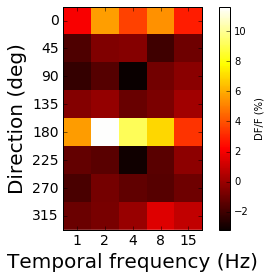

In [4]:
# skip the blank sweep column of the temporal frequency dimension
plt.imshow(dg.response[:,1:,cell_loc,0], cmap='hot', interpolation='none')
plt.xticks(range(5), dg.tfvals[1:])
plt.yticks(range(8), dg.orivals)
plt.xlabel("Temporal frequency (Hz)", fontsize=20)
plt.ylabel("Direction (deg)", fontsize=20)
plt.tick_params(labelsize=14)
cbar= plt.colorbar()
cbar.set_label("DF/F (%)")

The `peak` property of the analysis object is a Pandas DataFrame of peak conditions (direction and temporal frequency) as well as computed response metrics.  For drifting gratings this includes:

    ori_dg: preferred direction (index into dg.orivals)
    tf_dg: preferred temporal frequency (index into tf.tfvals)
    response_reliability_dg: response reliability 
    osi_dg: orientation selectivity index
    dsi_dg: direction selectivity index
    ptest_dg: number of signficant cells
    p_run_dg: K-S statistic comparing running trials to stationary trials
    run_modulation_dg: ratio of mean fluorescence during running vs static
    cv_dg: circular variance 

In [5]:
dg.peak.loc[cell_loc]

ori_dg                         4
tf_dg                          2
reliability_dg          0.194066
osi_dg                   1.21454
dsi_dg                  0.340134
peak_dff_dg              11.6263
ptest_dg             3.03061e-21
p_run_dg               0.0638074
run_modulation_dg        -0.6221
cv_os_dg                       1
cv_ds_dg                0.340134
tf_index_dg             0.297836
cell_specimen_id       517425074
Name: 97, dtype: object

Next let's plot all trials for a given cell's preferred condition.

In [6]:
pref_ori = dg.orivals[dg.peak.ori_dg[cell_loc]]
pref_tf = dg.tfvals[dg.peak.tf_dg[cell_loc]]
print("Preferred direction:", pref_ori)
print("Preferred temporal frequency:", pref_tf)

('Preferred direction:', 180)
('Preferred temporal frequency:', 2)


In [7]:
pref_trials = dg.stim_table[(dg.stim_table.orientation==pref_ori)&(dg.stim_table.temporal_frequency==pref_tf)]
pref_trials

,temporal_frequency,orientation,blank_sweep,start,end
1,2,180,0,836,896
71,2,180,0,7156,7216
73,2,180,0,7337,7397
100,2,180,0,9775,9834
141,2,180,0,13477,13536
175,2,180,0,16548,16607
271,2,180,0,55013,55073
291,2,180,0,56819,56878
323,2,180,0,59708,59768
435,2,180,0,97818,97878


`sweep_response` is a DataFrame that contains the DF/F of each cell during each stimulus trial. It shares its index with `stim_table`. Each cell contains a timeseries that extends from 1 second prior to the start of the trial to 1 second after the end of the trial. The final column of `sweep_response`, named `dx`, is the running speed of the mouse during each trial. The data in this DataFrame is used to create another DataFrame called `mean_sweep_response` that contains the mean DF/F during the trial for each cell (and the mean running speed in the last column).

In [8]:
subset = dg.sweep_response[(dg.stim_table.orientation==pref_ori)&(dg.stim_table.temporal_frequency==pref_tf)]

Here we look at the mean running speed during trials that presented the preferred condition.

In [9]:
subset_mean = dg.mean_sweep_response[(dg.stim_table.orientation==pref_ori)&(dg.stim_table.temporal_frequency==pref_tf)]
subset_mean['dx']

1       0.920868
71      0.060151
73      0.027268
100     4.897258
141    -0.000856
175    -0.002599
271    38.010730
291     0.000437
323    36.139884
435    -0.012866
449    11.234307
488     5.972907
509     1.967057
518    -0.004841
606     6.747042
Name: dx, dtype: float64

Plot the response to each trial of the preferred condition, labeled with the mean running speed during the trial

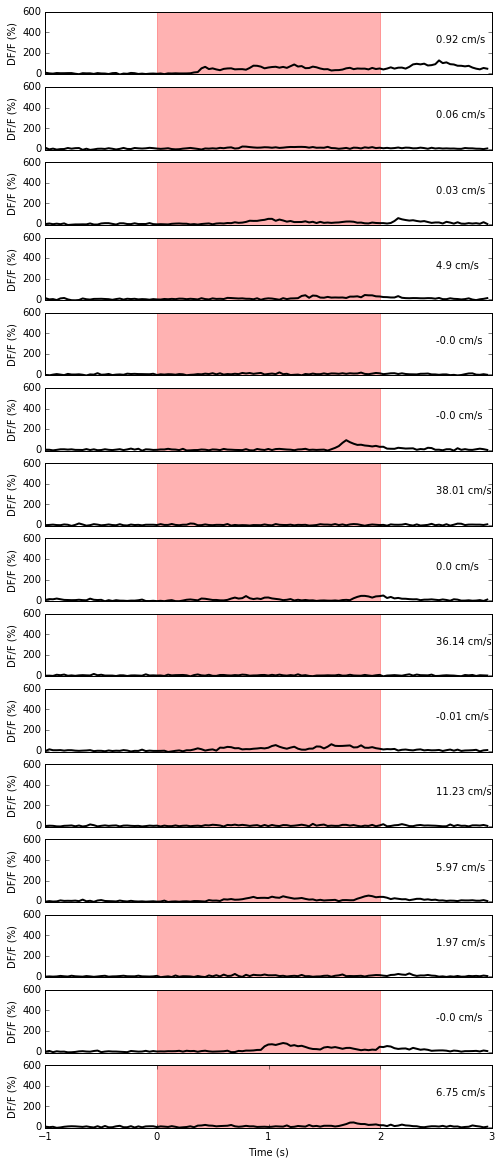

In [10]:
trial_timestamps = np.arange(-1*dg.interlength, dg.interlength+dg.sweeplength, 1.)/dg.acquisition_rate
plt.figure(figsize=(8,20))
for i in range(len(subset)):
    plt.subplot(len(pref_trials),1,i+1)
    plt.plot(trial_timestamps, subset[str(cell_loc)].iloc[i], color='k', lw=2)
    plt.axvspan(0,2,color='red', alpha=0.3)
    plt.ylabel("DF/F (%)")
    plt.ylim(-10,600)
    plt.yticks(range(0,700,200))
    plt.text(2.5, 300, str(round(subset_mean['dx'].iloc[i],2))+" cm/s")
    if i<(len(subset)-1):
        plt.xticks([])
    else:
        plt.xticks([-1,0,1,2,3])
        plt.xlabel("Time (s)")

## Static Gratings
The static gratings analysis object is quite similar to the drifting gratings analysis object.  Here we'll just take a look at the `peak` table, which contains information about the preferred orientation, spatial frequency, phase, as well as a number of other metrics.

In [11]:
from allensdk.brain_observatory.static_gratings import StaticGratings

# example loading drifing grating data
data_set = boc.get_ophys_experiment_data(510938357)

sg = StaticGratings(data_set)

In [12]:
sg.peak.head()

,ori_sg,sf_sg,phase_sg,reliability_sg,osi_sg,peak_dff_sg,ptest_sg,time_to_peak_sg,cell_specimen_id,p_run_sg,cv_os_sg,run_modulation_sg,sf_index_sg
0,4,2,1,0.0113189,0.285308,3.36311,0.559699,0.6634,517399188,0.898808,0.313745,0.193421,0.193012
1,5,3,3,0.0328444,0.856061,17.1593,5.6698e-07,0.46438,517399994,0.102605,0.792459,0.716304,0.272816
2,4,3,3,0.0140488,0.918923,4.73641,0.81548,0.36487,517399857,0.118354,0.602649,0.870513,0.218487
3,5,5,1,-0.00940717,1.05556,2.29522,0.0635452,0.36487,517399727,0.259146,0.914524,1.05157,0.145557
4,3,5,0,-0.00875107,0.378599,3.99094,0.0794371,0.86242,517399442,0.112734,0.318078,0.958211,0.204495


## Natural Scenes
The natural scenes analysis object is again similar to the others.  In addition to computing the `sweep_response` and `mean_sweep_response` arrays, `NaturalScenes` reports the cell's preferred scene, running modulation, time to peak response, and other metrics.

In [13]:
from allensdk.brain_observatory.natural_scenes import NaturalScenes

data_set = boc.get_ophys_experiment_data(510938357)

ns = NaturalScenes(data_set)
print("done analyzing natural scenes")

done analyzing natural scenes


In [14]:
ns.peak.head()

,scene_ns,reliability_ns,peak_dff_ns,ptest_ns,p_run_ns,run_modulation_ns,time_to_peak_ns,cell_specimen_id,image_selectivity_ns
0,48,0.0183184,4.91692,0.241369,0.0814777,-1.04747,0.76291,517399188,0.307441
1,96,0.151659,7.58865,2.77309e-08,0.0145825,-1.24205,0.36487,517399994,0.523847
2,103,-0.0106162,2.51431,0.0333866,0.0991697,1.01418,0.3317,517399857,-0.000474576
3,15,0.0047568,1.65234,0.577975,0.156953,1.04387,0.03317,517399727,0.176847
4,21,0.000218728,1.55928,0.0684794,0.428506,0.539678,0.56389,517399442,0.242186


## Locally Sparse Noise
The locally sparse noise stimulus object is a bit different from the others.  It does not have a peak condition table, instead providing a method to retrieve the "on" and "off" receptive fields of all cells.  The receptive field of a cell is computed by averaging responses to trials in which a given sparse noise grid location is on/off.

In [15]:
from allensdk.brain_observatory.locally_sparse_noise import LocallySparseNoise
import allensdk.brain_observatory.stimulus_info as stim_info

specimen_id = 517410165
cell = boc.get_cell_specimens(ids=[specimen_id])[0]

exp = boc.get_ophys_experiments(experiment_container_ids=[cell['experiment_container_id']],
                                stimuli=[stim_info.LOCALLY_SPARSE_NOISE])[0]
                                         
data_set = boc.get_ophys_experiment_data(exp['id'])
lsn = LocallySparseNoise(data_set)
print("done analyzing locally sparse noise")

done analyzing locally sparse noise


/local1/anaconda/lib/python2.7/site-packages/numpy/ma/core.py:4089: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


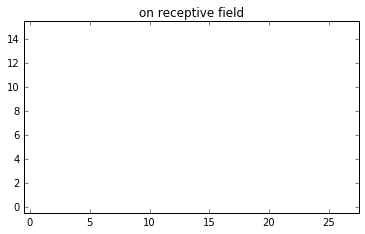

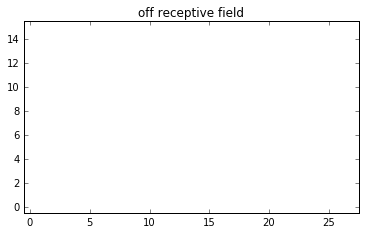

In [16]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

specimen_ids = data_set.get_cell_specimen_ids()
cell_loc = np.argwhere(specimen_ids==specimen_id)[0][0]

plt.imshow(lsn.receptive_field[:,:,cell_loc,0], interpolation='nearest', cmap='PuRd', origin='lower')
plt.title("on receptive field")
plt.show()
plt.imshow(lsn.receptive_field[:,:,cell_loc,1], interpolation='nearest', cmap='Blues', origin='lower')
plt.title("off receptive field")
plt.show()